<a href="https://colab.research.google.com/github/sahithi-777/ML/blob/main/Telco_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Drop ID column
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric and drop NaNs
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical columns
df = pd.get_dummies(df, drop_first=True)

# Feature scaling for numeric columns
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

# Split into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)


In [7]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)



Logistic Regression Results:
Accuracy: 0.7867803837953091
Confusion Matrix:
 [[915 118]
 [182 192]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Random Forest Results:
Accuracy: 0.7846481876332623
Confusion Matrix:
 [[926 107]
 [196 178]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407


XGBoost Results:
Accuracy: 0.7739872068230277
Confusion Matrix:
 [[903 130]
 [188 186]]
Classificatio

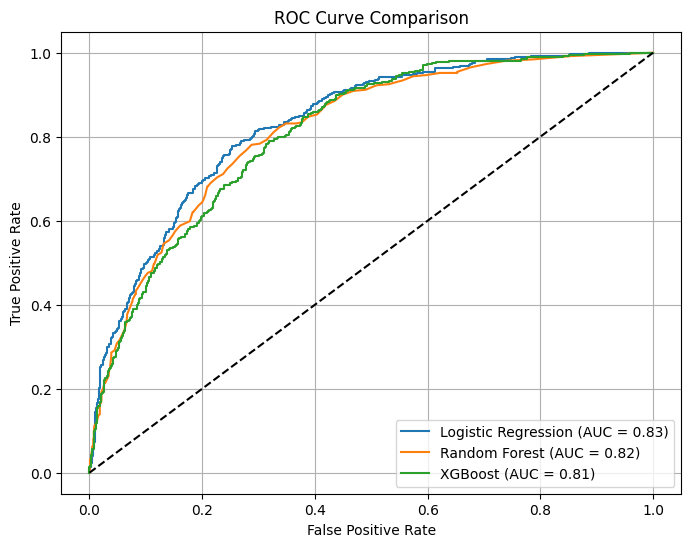

In [8]:
def plot_roc_curve(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')

plt.figure(figsize=(8,6))
plot_roc_curve(lr, X_test, y_test, "Logistic Regression")
plot_roc_curve(rf, X_test, y_test, "Random Forest")
plot_roc_curve(xgb_model, X_test, y_test, "XGBoost")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


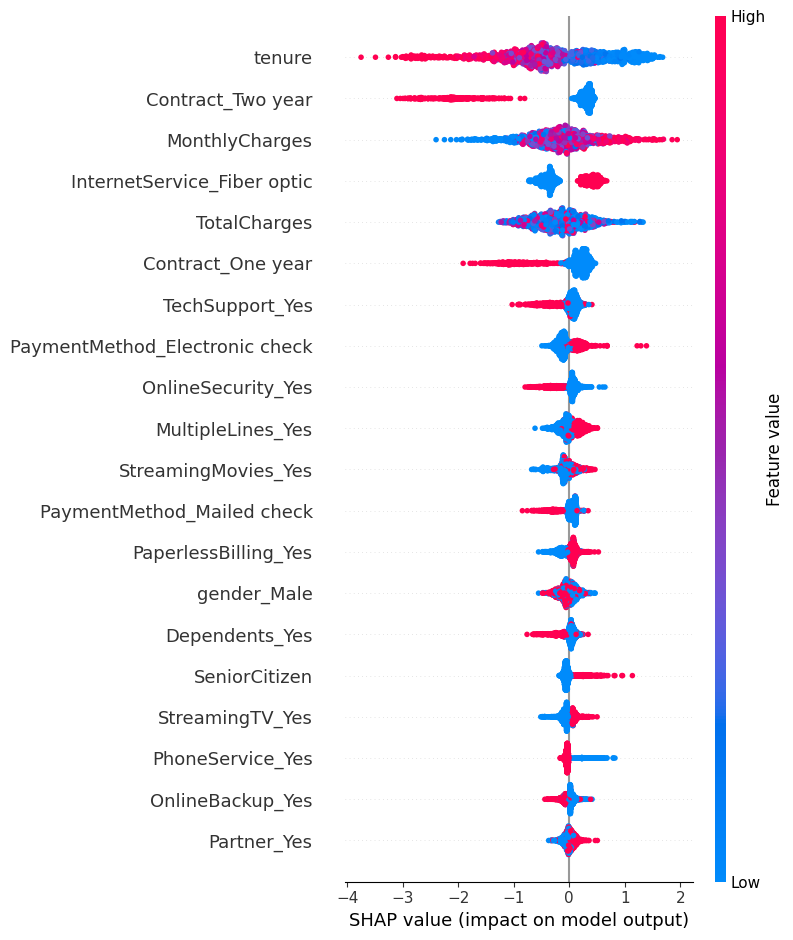

In [9]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


In [10]:
def test_customer_all_models(input_dict):
    # Convert to DataFrame
    df = pd.DataFrame([input_dict])

    # Scale numeric values
    df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

    # Add missing one-hot columns
    for col in X.columns:
        if col not in df.columns:
            df[col] = 0
    df = df[X.columns]  # reorder columns

    # Predictions
    lr_pred = lr.predict(df)[0]
    rf_pred = rf.predict(df)[0]
    xgb_pred = xgb_model.predict(df)[0]

    print("✅ Logistic Regression:", "Churn" if lr_pred == 1 else "No Churn")
    print("✅ Random Forest     :", "Churn" if rf_pred == 1 else "No Churn")
    print("✅ XGBoost           :", "Churn" if xgb_pred == 1 else "No Churn")

    return df  # return for SHAP use


In [11]:
sample_input = {
    'tenure': 5,
    'MonthlyCharges': 70.5,
    'TotalCharges': 300.5,
    'gender_Male': 1,
    'Partner_Yes': 0,
    'Dependents_Yes': 0,
    'PhoneService_Yes': 1,
    'MultipleLines_Yes': 1,
    'InternetService_Fiber optic': 1,
    'InternetService_No': 0,
    'OnlineSecurity_Yes': 0,
    'OnlineBackup_Yes': 0,
    'DeviceProtection_Yes': 0,
    'TechSupport_Yes': 0,
    'StreamingTV_Yes': 1,
    'StreamingMovies_Yes': 1,
    'Contract_One year': 0,
    'Contract_Two year': 0,
    'PaperlessBilling_Yes': 1,
    'PaymentMethod_Electronic check': 1,
    'PaymentMethod_Mailed check': 0,
    'PaymentMethod_Credit card (automatic)': 0,
    'PaymentMethod_Bank transfer (automatic)': 0
}


In [12]:
df_for_shap = test_customer_all_models(sample_input)


✅ Logistic Regression: Churn
✅ Random Forest     : Churn
✅ XGBoost           : Churn


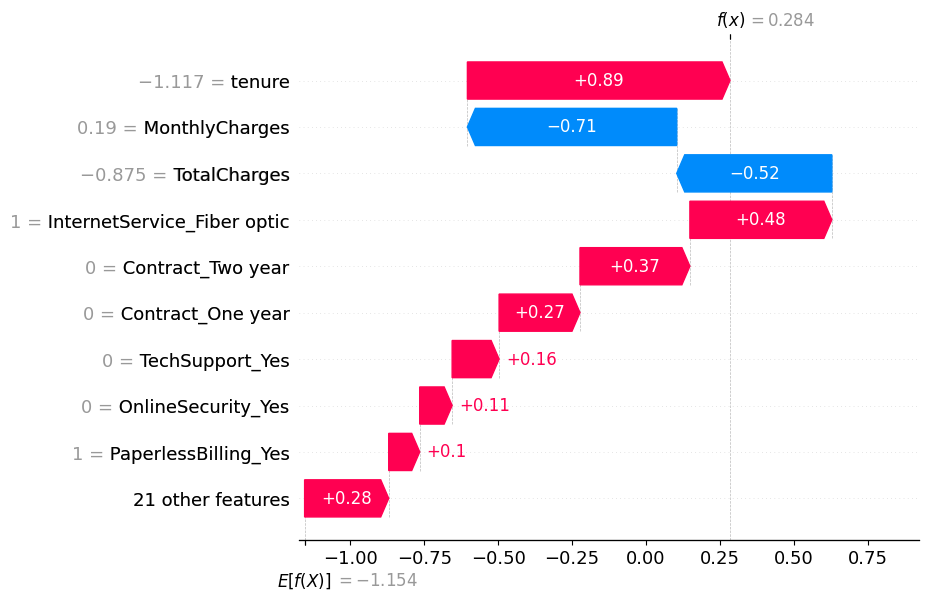

In [13]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(df_for_shap)

shap.plots.waterfall(shap_values[0])
